In [464]:
from typing import Annotated, Dict, Any
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, BaseMessage
from langgraph.types import Command, interrupt
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import InMemorySaver
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import Chroma
from dateparser import parse as parse_date
from pydantic import BaseModel, Field
from datetime import datetime
import asyncio
import requests
import re
import random
import time
import os


In [465]:
llm = ChatOllama(model="llama3.2", base_url="http://localhost:11434")

In [466]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    chart_of_account: dict

### All required schemas


In [467]:
class CurrencySchema(BaseModel):
    currency_id: int = Field(
        description="ID of the currency used for the journal entry (e.g., USD, EUR, INR)"
    )

class StatusSchema(BaseModel):
    status_id: int = Field(
        description="ID representing the status of the journal entry (e.g., draft, closed, posted)"
    )

class AccountsSchema(BaseModel):
    debit_account_id: int = Field(
        description="ID of the debit account (e.g., Cash, Inventory, Expense)"
    )
    credit_account_id: int = Field(
        description="ID of the credit account (e.g., Sales Revenue, Bank, Accounts Receivable)"
    )

### Tools

In [468]:
@tool
def retriever(query: str):
    """Use this tool to search a knowledge base of accounting and product documents and return relevant information based on the user's query."""
    base_dir = os.getcwd()
    accounting_file_path = os.path.join(base_dir, "financials.txt")
    product_file_path = os.path.join(base_dir, "product_help.txt")

    product_loader = TextLoader(product_file_path)
    accounting_loader = TextLoader(accounting_file_path)

    product_docs = product_loader.load()
    accounting_docs = accounting_loader.load()

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
    product_chunks = text_splitter.split_documents(product_docs)
    for doc in product_chunks:
        doc.metadata["type"] = "product"

    accounting_chunks = text_splitter.split_documents(accounting_docs)
    for doc in accounting_chunks:
        doc.metadata["type"] = "accounting"
    docs = product_chunks + accounting_chunks

    embeddings = OllamaEmbeddings(
        model="llama3.2", base_url="http://localhost:11434"
    )
    vectorstore = Chroma.from_documents(
        documents=docs,
        embedding=embeddings,
        persist_directory="chroma_db",
    )
    vectorstore.persist()
    retrieved_docs = vectorstore.similarity_search(query, k=5)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    # print("serialized retrieved_docs", retrieved_docs)
    return serialized, retrieved_docs


In [469]:
from langgraph.prebuilt import InjectedState
@tool
def create_journal_entry(
    state: Annotated[dict, InjectedState],
    name: str = None,
    date: str = None,
    debit_account: str = None,
    credit_account: str = None,
    credit_amount: str = None,
    debit_amount: str = None,
    description: str = "",
    currency: str = "",
    status: str = "",
) -> dict:
    """
    Tool to create a new journal entry in the system.
    """

    # Ensure COA exists
    coa = state.setdefault("chart_of_account", {})

    # Merge newly provided values into state
    if name: coa["name"] = name
    if date: coa["date"] = date
    if debit_account: coa["debit_account"] = debit_account
    if credit_account: coa["credit_account"] = credit_account
    if credit_amount: coa["credit_amount"] = credit_amount
    if debit_amount: coa["debit_amount"] = debit_amount
    if description: coa["description"] = description
    if currency: coa["currency"] = currency
    if status: coa["status"] = status

    # Apply defaults if still missing
    coa.setdefault("date", datetime.now().strftime("%Y-%m-%d"))
    coa.setdefault("status", "draft")
    coa.setdefault("currency", "USD")

    # Required fields
    required_fields = ["name", "debit_account", "credit_account", "debit_amount", "credit_amount"]
    missing = [field for field in required_fields if not coa.get(field)]

    # Build structured message
    message_lines = []
    message_lines.append("Current journal entry details:")
    for key, value in coa.items():
        if value:
            message_lines.append(f"{key}: {value}")

    if missing:
        message_lines.append("\nPlease provide the following missing fields:")
        for field in missing:
            message_lines.append(f"{field}: (missing)")

        return "\n".join(message_lines)

    # Convert amounts to floats
    def parse_amount(amount_str):
        try:
            cleaned = re.sub(r'[^\d\.]', '', str(amount_str))
            return float(cleaned)
        except Exception:
            return None

    coa["debit_amount"] = parse_amount(coa["debit_amount"])
    coa["credit_amount"] = parse_amount(coa["credit_amount"])

    if coa["debit_amount"] != coa["credit_amount"]:
        return "Debit and credit amounts must be equal."

    # Final journal entry payload
    journal_entry = {
        "name": coa["name"],
        "date": coa["date"],
        "currency": coa["currency"],
        "status": coa["status"],
        "description": coa.get("description", ""),
        "entries": [
            {"account": coa["debit_account"], "debit": coa["debit_amount"], "credit": 0},
            {"account": coa["credit_account"], "debit": 0, "credit": coa["credit_amount"]},
        ]
    }

    return "Journal entry created successfully.",
    try:
        fetch_logged_in_user = "https://gl.vteamslabs.com/api/users/me/"
        

        logged_in_user_response = requests.get(fetch_logged_in_user, headers=headers)
        logged_in_user_response.raise_for_status()
        logged_in_user_data = logged_in_user_response.json()
    except requests.RequestException as e:
        return f"Failed to fetch common settings.{e}"

    try:
        fetch_settings_url = "https://gl.vteamslabs.com/api/common-settings/"
        fetch_accounts_url = (
            "https://gl.vteamslabs.com/chart-of-accounts/accounts/1"
        )

        settings_response = requests.get(fetch_settings_url, headers=headers)
        settings_response.raise_for_status()
        settings_data = settings_response.json()
    except requests.RequestException as e:
        return f"Failed to fetch common settings. {e}"
    try:
        accounts_response = requests.get(fetch_accounts_url, headers=headers)
        accounts_response.raise_for_status()
        accounts_data = accounts_response.json()
    except requests.RequestException as e:
        return "Failed to fetch chart of accounts." + e

    def flatten_accounts(accounts):
        flat = []
        for account in accounts:
            flat.append(account)
            if account.get("sub_accounts"):
                flat.extend(flatten_accounts(account["sub_accounts"]))
        return flat

    flat_accounts = flatten_accounts(accounts_data)

    filtered_accounts = [
        {"id": acc["id"], "name": acc["name"], "description": acc["description"]}
        for acc in flat_accounts
    ]

    currency_prompt = f"""
        From this list of currencies:
        {settings_data["currencies"][::-1]}

        Find the currency that best matches the input: "{currency}"

        Return:
        {{ "currency_id": int }}
        """
    currency_llm=llm.with_structured_output(CurrencySchema)
    currency_data = currency_llm.invoke(currency_prompt)
    # print("logged_in_user_data:", logged_in_user_data)
    # print("logged_in_user_data12:", logged_in_user_data.get("default_currency")['id'])

    status_prompt = f"""
    From this list of statuses:
    {settings_data["journal_statuses"]}

    Find the status that best matches the input: "{status}"

    Return:
    {{ "status_id": int }}
    """
    status_llm=llm.with_structured_output(StatusSchema)
    status_data = status_llm.invoke(status_prompt)
    # print("status_data:", status_data)

    prompt = f"""
        You are a financial assistant. Given the following chart of account JSON:

        {filtered_accounts}

        Your task:
        - Find the **most relevant chart of account** as `debit_account` whose name or type matches **"{debit_account}"**.
        - Find the **most relevant chart of account** as `credit_account` whose name or type matches **"{credit_account}"**.
        - Return ONLY the `id` and `name` fields of the matched account objects.
        - DO NOT return `account_number` or any other fields.
        - If no matching account is found, return `null`.

        Return this structured output strictly as JSON:
        {{
        "debit_account": {{
            "id": int,
            "name": str
        }},
        "credit_account": {{
            "id": int,
            "name": str
        }}
        }}
        """
    accounts_llm=llm.with_structured_output(AccountsSchema)
    accounts_data = accounts_llm.invoke(prompt)
    print("accounts_data:", accounts_data)

    payload = {
        "date": date,
        "description": description,
        "name": name,
        "number": number,
        "currency": logged_in_user_data.get("default_currency")['id'] if not currency else currency_data.currency_id,
        "status": status_data.status_id,
        "entries": [
            {
                "account": accounts_data.debit_account_id,
                "debit": debit_amount or credit_amount or 1,
                "credit": 0,
            },
            {
                "account": accounts_data.credit_account_id,
                "debit": 0,
                "credit": credit_amount or debit_amount or 1,
            },
        ],
    }
    # print("final_payload:", payload)
    try:
        create_url = "https://gl.vteamslabs.com/api/journal-entry/1/"
        response = requests.post(create_url, json=payload, headers=headers)
        response.raise_for_status()
        response_data = response.json()
        print("response_data_after_create:", response_data)
        return (
            f"Journal entry created:\n Name: {response_data['name']}\n "
            f"Number: {response_data['number']}\n"
        )

    except requests.RequestException as e:
        return f"Failed to create journal entry. {e}"

In [470]:
tools = [retriever, create_journal_entry]
# A node
tools_node = ToolNode(tools)

In [471]:
# A node
def query_or_response(state: State):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools(tools)

    system_message_content = """
                You are a helpful assistant that uses internal tools to fulfill user requests. 
                Do not expose or explain internal tool names or implementation details to the user. 
                Responses should be natural and friendly. Use tools silently when necessary. 
                Be concise and direct in your responses. Avoid lengthy explanations unless specifically requested. 
                Always remember previous messages and maintain context throughout the conversation.
                When user provide the id of the account as the follow up question then simple call the update_chart_of_account tool

                You can use the following tools:
                - Use 'create_journal_entries' when the user wants to create a journal entry.
                - Use 'retriever' for informational questions or explanations related to the GL website, login/signup process, features, roles, etc.
                - Never call tools for unrelated or unclear prompts like “create a hello world app” or random text like “asdf”.

                If the user greets (e.g., says "hi", "hello"), respond with a brief greeting and ask how you can assist with accounting-related tasks.

                If the user's question is not related to the accounting software or GL website, reply with:
                "Please ask questions related to the accounting software or GL website."

                ### Examples:

                User: "Hi"
                Assistant: "Hello! How can I assist you with accounting-related tasks today?"

                User: "What’s the best role for managing chart of accounts?"
                → Use 'retriever'
                Assistant: "Typically, roles like Finance Manager or Accountant have access to manage chart of accounts."

                User: "How to sign up on the platform?"
                → Use 'retriever'
                Assistant: "To sign up, go to the GL website and click on the SignUp button..."

                User: "Create a hello world app"
                → No tool call
                Assistant: "Please ask questions related to the accounting software or GL website."

                User: "asdfasd"
                → No tool call
                Assistant: "Please ask questions related to the accounting software or GL website."
                """

    prompt = [SystemMessage(system_message_content)] + state["messages"]
    response = llm_with_tools.invoke(prompt)
    # print("Tool_response12:", response)
    return {"messages": [response]}

# A node
def generate(state: State):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]
    print("tool_messages", tool_messages)
    # Check if this is a tool response that should be returned directly
    if tool_messages[0].content:
        tool_name = tool_messages[0].name
        if tool_name in [
            "create_journal_entry",
            "create_chart_of_account",
            "update_chart_of_account",
        ]:
            tool_reply = tool_messages[0].content
            if tool_name in ["create_chart_of_account", "update_chart_of_account"]:
                tool_name = "chart_of_account"
            else:
                tool_name = "journal_entry"
            return {
                "messages": [
                    AIMessage(
                        content=tool_reply,
                        name=tool_name,
                        tool_call_id=tool_messages[0].tool_call_id,
                    )
                ]
            }

    # # For retriever tool or other cases, use LLM to generate response
    docs_content = "\n\n".join(
        msg.content.strip()
        for msg in tool_messages
        if hasattr(msg, "content") and msg.content
    )

    # print("docs_content12", docs_content)

    system_message_content = (
        "Note: Currently, we do not support functionality for deleting or updating journal entries.\n"
        "We only support:\n"
        "- Creating journal entries\n"
        "- Creating and updating chart of accounts\n\n"
        "Answer should be concise.\n"
        "If the user's message is vague, unrelated to accounting, or does not contain a clear question, DO NOT call any tools."
        "Instead, reply with: 'Please ask a question related to accounting-related tasks.'"
        "You are a helpful assistant that uses internal tools to fulfill user requests.\n"
        "Do not create anything if the user input is vague or unrelated (e.g., 'create hello world').\n"
        "Do not expose or explain internal tool names or implementation details to the user.\n"
        "Responses should be natural and friendly.\n"
        "Be concise and direct in your responses.\n"
        "Avoid lengthy explanations unless specifically requested.\n"
        "If the user greets, respond with a brief greeting and ask how you can assist with accounting-related tasks.\n"
        "When a user asks to create or retrieve something, use the available tools to complete the task.\n"
        "Never include Python code in the response.\n"
        "If any link is provided like sign-in, sign-up, etc., add the anchor tag with attribute target='_blank'.\n"
        "Use the tools when the user asks to create accounts or journal entries.\n"
        "Never call a creation tool if the user mentions deleting, editing, updating, renaming, or failed actions unless they explicitly say to create a new one.\n"
        "If a user says something like 'delete' or 'unable to delete', ask for clarification or reply: 'Currently, deletion is not supported. Please let me know if you want to create something new.'\n"
        "Remember details from earlier in the conversation (e.g., user's name or previous questions).\n"
        "Maintain conversation context and refer back to earlier inputs when relevant.\n\n"
        # Few-shot examples
        "### Examples:\n"
        "**User:** Hello\n"
        "**Assistant:** Hello! How can I assist you with your accounting tasks today?\n\n"
        "**User:** create hello world\n"
        "**Assistant:** I'm here to help with accounting tasks like creating journal entries or chart of accounts. Could you clarify what you'd like to do?\n\n"
        "**User:** I want to delete an account\n"
        "**Assistant:** Currently, deletion is not supported. Please let me know if you want to create something new.\n\n"
        "**User:** How do I login?\n"
        "**Assistant:** To login to the system, go to <a href='https://gl.vteamslabs.com/login' target='_blank'>https://gl.vteamslabs.com/login</a>, enter your email and password, and click Login.\n\n"
        "**User:** What is a ledger?\n"
        "**Assistant:** A ledger is a book or digital record where all journal entries are posted to individual accounts. It helps track the balance of each account and prepares data for the trial balance and financial statements.\n\n"
        "**User:** Can you create a journal entry for me?\n"
        "**Assistant:** Sure, please provide the necessary details to create the journal entry (e.g., date, accounts, and amounts).\n\n"
        "*User:** Hello"
        "**Assistant:** Hello! How can I assist you with accounting-related tasks today?"
        "**User:** GL user name  "
        "**Assistant:** Please ask a question related to accounting-related tasks."
        "**User:** test chart  "
        "**Assistant:** Please ask a question related to accounting-related tasks."
        "**User:** something is wrong "
        "**Assistant:** Please ask a question related to accounting-related tasks."
        "**User:** What is a journal?"
        "**Assistant:** A journal is a chronological record of all financial transactions..."
        "**User:** Can I create a chart of account?"
        "**Assistant:** Sure, I can help you create a chart of account. Please provide the necessary details."
        f"{docs_content}"
    )

    # Build conversation messages excluding tool calls for cleaner context
    conversation_messages = []
    for message in state["messages"]:
        if message.type in ("human", "system"):
            conversation_messages.append(message)
        elif message.type == "ai" and not message.tool_calls:
            conversation_messages.append(message)

    prompt = [SystemMessage(system_message_content)] + conversation_messages
    response = llm.invoke(prompt)
    # print("Generated response:", response.pretty_print())
    return {"messages": [response]}


In [472]:
memory = InMemorySaver()

In [473]:
graph_builder = StateGraph(State)
    
    # Add nodes
graph_builder.add_node("query_or_response", query_or_response)
graph_builder.add_node("tools", tools_node)
graph_builder.add_node("generate", generate)

# Set entry point
graph_builder.set_entry_point("query_or_response")

# Add edges - simplified flow
graph_builder.add_conditional_edges(
    "query_or_response",
    tools_condition,
    {"tools": "tools", "generate": "generate"}  # Either use tools OR go direct to generate
)

# Tools always go to generate (no retry loops)
graph_builder.add_edge("tools", "generate")

# Generate always ends (simplified)
graph_builder.add_edge("generate", END)

# Compile the graph
graph = graph_builder.compile(checkpointer=memory)

In [474]:
config = {"configurable": {"thread_id": '1'}}

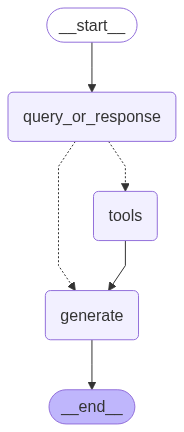

In [475]:
graph

In [479]:
user_input = "name: Shoping Entry"
llm_output = graph.invoke(
    {"messages": [{"role": "user", "content": user_input}]}, config
)
print(llm_output['messages'][-1].content)


# llm_output = graph.invoke(
#     {
#         "messages": [{"role": "user", "content": user_input}],
#         "chart_of_account": {
#             "default_account": "Cash",
#             "currency": "USD",
#             "accounts": ["Cash", "Bank", "Sales Revenue"]
#         }
#     },
#     config
# )
# print(llm_output['messages'][-1].content)

tool_messages [ToolMessage(content='["Journal entry created successfully."]', name='create_journal_entry', id='38714bef-03c4-410e-8dcc-3b95f4a321be', tool_call_id='3f413d21-389e-4bc2-8b96-75829903617e')]
["Journal entry created successfully."]


In [477]:
# user_input = "How I can reset my password? "
# for chunk in graph.stream(
#     {"messages": [{"role": "user", "content": user_input}]},
#     config
# ):
#     # Check if this chunk is from the 'generate' node
#     if 'generate' in chunk and 'messages' in chunk['generate']:
#         content = chunk['generate']['messages'][-1].content
#         if content:
#             print(content, end='', flush=True)
